**NOTE** computing overlap based on string matches in the responses showed that there are a number of exact duplicates in the training data. This means that certain splits contain more duplicate responses than others and the size/amount of overlap differs quite a bit (up to 8K items).

If we use the input reviews, or rrgen_ids, the training sets are approximately the same size and overlap is around 50% for most training sets.

In [1]:
from pathlib import Path
import numpy as np
from collections import Counter
import pprint
import matplotlib.pyplot as plt
import seaborn as sns

# import matplotlib as mpl
# mpl.rcParams.update(mpl.rcParamsDefault)
# mpl.rcParams['text.usetex'] = True

fontsize = 11
textwidth = 5.9  # inches
sns.set_context("paper", font_scale=1.3, rc={'lines.linewidth': 0.75,
                                             'axes.linewidth': 0.75,
                                             'font.size': fontsize,
                                            #  'font.variant': 'small-caps',
                                             'axes.labelsize': fontsize,
                                             'xtick.labelsize': fontsize,
                                             'ytick.labelsize': fontsize,
                                             'legend.fontsize': fontsize,
                                             'text.usetex': False
                                             })

In [2]:
data_dir = Path('../../data/hotel/')

train_sets = {
    'filt_freq_distro_0.0_0.883': 'lex. freq.',
#     'filt_response_tfidf_1.37_1.8': 'tgt TF-IDF',
    'filt_generic_sent_avg_0.0_0.7': 'sent. avg.',
    'filt_tgt_ppl_23.5_50': 'LM PPL',
#     'filt_rev_resp_tfidf_0.118_0.6': 'src-tgt TF-IDF',
#     'filt_rev_resp_sts_0.51_0.8': 'src-tgt STS',
    }

In [3]:
def collect_counted_lines(file):
    with open(file, 'r', encoding='utf8') as f:
        return Counter([line.strip() for line in f])

data_responses = {}
for k, v in train_sets.items():
    id_file = Path(data_dir) / k / 'train.response'
    data_responses[v] = collect_counted_lines(id_file)
    
for i, ik in enumerate(data_responses.keys()):
    print(ik)
    pprint.pprint(data_responses[ik].most_common(3))
    print()

lex. freq.
[('Hello, Thank you for taking the time to review Mantra Lorne. Your feedback '
  'has been correlated and will assist us in targeting areas for improvement, '
  'so thank you for sharing your experience. Cheers Abraham',
  231),
 ('Thank you for taking the time to complete our guest survey about your '
  'recent experience at The Ambassador Hotel & Conference Centre. Your '
  'feedback is critical to our continued improvement and success! We hope you '
  'will come back and stay with us again soon. Please contact me personally to '
  'arrange your next visit so I can ensure your next stay is nothing less than '
  'exceptional. Warm Regards, Ashley MacGillivray | Guest Services Manager '
  'ashley.macgillivray@ambassadorhotel.com Phone: 613-548-3605 | '
  '1-800-267-7880',
  70),
 ('Dear Valued Guest, We thank you for choosing the LaQuinta Inn & Suites '
  'Indianapolis Downtown, Your feedback is crucial to us as we strive to excel '
  'in every aspect of your stay. We are t

In [4]:
def collect_ids(file):
    with open(file, 'r', encoding='utf8') as f:
        return set([int(line.strip()) for line in f])

data = {}
for k, v in train_sets.items():
    id_file = Path(data_dir) / k / 'train.rrgen_id'
    data[v] = collect_ids(id_file)
    
# for k in data.keys():
#     print(len(data[k]))

In [5]:
m = np.zeros((len(data), len(data)), dtype=np.int32)
m_perc = np.zeros((len(data), len(data)), dtype=np.int32)

for i, ik in enumerate(data.keys()):
    for j, jk in enumerate(data.keys()):
#         print(ik, jk)
        intersect = data[ik].intersection(data[jk])
        m[i][j] = len(intersect)
        m_perc[i][j] = round(len(intersect) / len(data[ik]) * 100)
        
# print(m)
# print(m_perc)

In [6]:
# create masks for overlaying the matrices
# top-right contains percentage overlap
# bottom-left contains raw counts

mask_u = np.zeros_like(m)
mask_u[np.triu_indices_from(m, 1)] = True
mask_l = np.zeros_like(m)
mask_l[np.tril_indices_from(m, 0)] = True

# print(mask_u)
# print(mask_l)

m = m * mask_l
m_perc = m_perc * mask_u
m = m+m_perc
print(m)


[[183885     65     57]
 [119992 182741     57]
 [105088 103992 181924]]


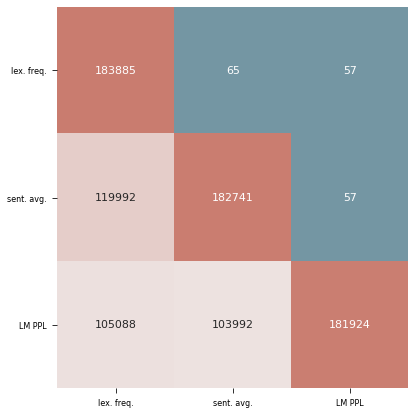

In [7]:
# create heatmap plot
cm = sns.diverging_palette(220, 20, s=40, l=60, as_cmap=True)
with plt.style.context('seaborn-paper'):
    # sns.set(font_scale=1.4)
    f, ax = plt.subplots(1, 1, figsize=(textwidth, textwidth))
#     print(axes)
    sns.heatmap(m, annot=True, fmt="d", cmap=cm, xticklabels=list(data.keys()), yticklabels=list(data.keys()), ax=ax, cbar=False)
    plt.yticks(rotation=0)
    plt.tight_layout()
    # plt.savefig('./plots/train_set_overlap_3.pdf', dpi=300)
    # plt.savefig('./plots/train_set_overlap_3.png', dpi=300)

[['183k' '65%' '57%']
 ['119k' '182k' '57%']
 ['105k' '103k' '181k']]
0 0 183k
0 1 65%
-0.65
0 2 57%
-0.57
1 0 119k
1 1 182k
1 2 57%
-0.57
2 0 105k
2 1 103k
2 2 181k


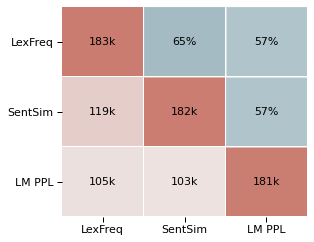

In [15]:
# Create a custom formatting function
def custom_format(x):
    if x >= 1000:
        return f"{int(x/1000)}k"
    else:
        return f"{x}%"

formatted_data = np.vectorize(custom_format)(m)
print(formatted_data)

name_map = {
    'lex. freq.': r'LexFreq',
    'sent. avg.': r'SentSim',
    'LM PPL': r'LM PPL',
}

xlabels = [name_map[label] for label in list(data.keys())]
ylabels = [name_map[label] for label in list(data.keys())]

cm = sns.diverging_palette(220, 20, s=40, l=60, as_cmap=True)

f, ax = plt.subplots(1, 1, figsize=(4.5, 3.5))

# set aspect to auto to ensure the aspect ratio is correct
ax.set_aspect('auto')

sns.heatmap(m, annot=False, fmt="", cmap=cm,
            xticklabels=xlabels, yticklabels=ylabels,
            ax=ax, cbar=False, linewidths=.5, cbar_kws={"shrink": .5})

# annotate with the formatted string
for i in range(m.shape[0]):
    for j in range(m.shape[1]):
        print(i, j, formatted_data[i, j])
        ax.text(j+0.5, i+0.5, formatted_data[i, j],
                ha='center', va='center', color='black', fontsize=fontsize)
        if m[i, j] < 100:
            # set the square background color alpha to the percentage
            alpha = -m[i, j] / 100
            print(alpha)
            ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='white', alpha=alpha))


plt.yticks(rotation=0)

plt.tight_layout()

plt.savefig('/home/user/kew/projects/diss_figs/rrgen_train_set_overlap.pdf', dpi=300)
plt.savefig('/home/user/kew/projects/diss_figs/rrgen_train_set_overlap.png', dpi=300)

# plt.show()